In [1]:
%matplotlib inline

## Generic Python imports
import os
import matplotlib.pyplot as plt

## Generic database imports
import pandas as pd
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Progress bar in Colab
from tqdm import tqdm

## Generic PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Install wandb on the device (only needed once if you are in local)
!pip install wandb --quiet
import wandb

In [2]:
# Then connect to your W&B account
def wandb_connect():
    wandb_api_key_label = "wandb_api_key"
    wandb_api_key = "" # here use your API key from WandB interface

    wandb_conx = wandb.login(key = wandb_api_key)
    print(f"Connected to Wandb online interface : {wandb_conx}")

wandb_connect()

wandb: Currently logged in as: leo-fillioux. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Connected to Wandb online interface : True


# Lab 4: Modern CNNs

In this exercise we are going to train a ResNet model on ImageNette: a dataset which is a subset of 10 easily classified classes from ImageNet. This small vision dataset is useful to practice your modeling skills because it is very similar to ImageNet but much less expensive to deal with.

In [3]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -O imagenette2-160.tgz
!tar zxvf imagenette2-160.tgz

Streaming output truncated to the last 5000 lines.
imagenette2-160/train/n03888257/n03888257_16077.JPEG
imagenette2-160/train/n03888257/n03888257_23339.JPEG
imagenette2-160/train/n03888257/n03888257_44204.JPEG
imagenette2-160/train/n03888257/n03888257_61633.JPEG
imagenette2-160/train/n03888257/n03888257_15067.JPEG
imagenette2-160/train/n03888257/n03888257_75365.JPEG
imagenette2-160/train/n03888257/n03888257_63966.JPEG
imagenette2-160/train/n03888257/n03888257_3927.JPEG
imagenette2-160/train/n03888257/n03888257_20684.JPEG
imagenette2-160/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-160/train/n03888257/n03888257_14016.JPEG
imagenette2-160/train/n03888257/n03888257_37776.JPEG
imagenette2-160/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-160/train/n03888257/n03888257_17513.JPEG
imagenette2-160/train/n03888257/n03888257_17143.JPEG
imagenette2-160/train/n03888257/n03888257_6738.JPEG
imagenette2-160/train/n03888257/n03888257_4355.JPEG
imagenette2-160/train/n03888257/ILS

As ImageNet, this dataset is organized by folders. The first folders are the split train and val. In each split folder, you find folders according to attributed labels of ImageNet.
The dataset also provide a .csv that we will study after.

In [4]:
!ls imagenette2-160

noisy_imagenette.csv  train  val


In [5]:
!ls imagenette2-160/train

n01440764  n02979186  n03028079  n03417042  n03445777
n02102040  n03000684  n03394916  n03425413  n03888257


The mapping from the labels to the classes is given by ImageNet. Here we selected these classes: tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute

In [6]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

Let's study the dataset with the .csv. As you see, it is constructed by the path of the image, the associated labels given the presence or not noise and the split. Here we are not interested in the labelling noise and choose it to be 0.

In [7]:
data_path = 'imagenette2-160'
df = pd.read_csv(f'{data_path}/noisy_imagenette.csv')
df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


Let's see the repartition of the splits and of the classes.

In [8]:
df.groupby(['is_valid'])['noisy_labels_0'].value_counts().rename(lbl_dict)

is_valid  noisy_labels_0  
False     cassette player     993
          tench               963
          garbage truck       961
          parachute           960
          French horn         956
          English springer    955
          golf ball           951
          church              941
          gas pump            931
          chain saw           858
True      gas pump            419
          church              409
          golf ball           399
          English springer    395
          French horn         394
          parachute           390
          garbage truck       389
          tench               387
          chain saw           386
          cassette player     357
Name: noisy_labels_0, dtype: int64

# Dataloader

We will now define the data transformations we will need. Data transformations are useful for multiple reasons: to normalize, to transform the raw images into Tensors and to perform data augmentations. Data augmentations are transforms that extends the **training** dataset by introducing controlled random perturbations on the input (like a random horizontal flip: our model should still be able to classify a tench whether it is shown head-fishtail or fishtail-head). Feel free to [add other data augmentation](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) if you think they make sense. Of course, there is no sense to augment the validation dataset as we need it to be the most likely data (other than [Test-Time Augmentation](https://www.kaggle.com/code/andrewkh/test-time-augmentation-tta-worth-it/notebook) which is an ensemble approach on multiple augmentations of the same data. We don't cover that in this course but you can read that during the training of your models.)

We will build the dataset with a standard function of torchvision: ImageFolder.

We construct the dataloaders.


In [9]:
mean = torch.Tensor([0.485, 0.456, 0.406]) # Channel mean of ImageNet
std = torch.Tensor([0.229, 0.224, 0.225]) # Channel standard Deviation of ImageNet
DeNormalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = 1/std), transforms.Normalize(mean = -mean, std = [ 1., 1., 1. ]),])
trn_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std), transforms.RandomRotation((0,180)), transforms.Resize((160, 200))]) # TODO
basic_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std), transforms.Resize((160, 200))]) # TODO

train_dataset = ImageFolder(root=f'{data_path}/train', transform=trn_transforms)
val_dataset = ImageFolder(root=f'{data_path}/val', transform=basic_transforms)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, drop_last=True)

Pay attention to the DeNormalization of the inputs as we iterate on the train_dataloader.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


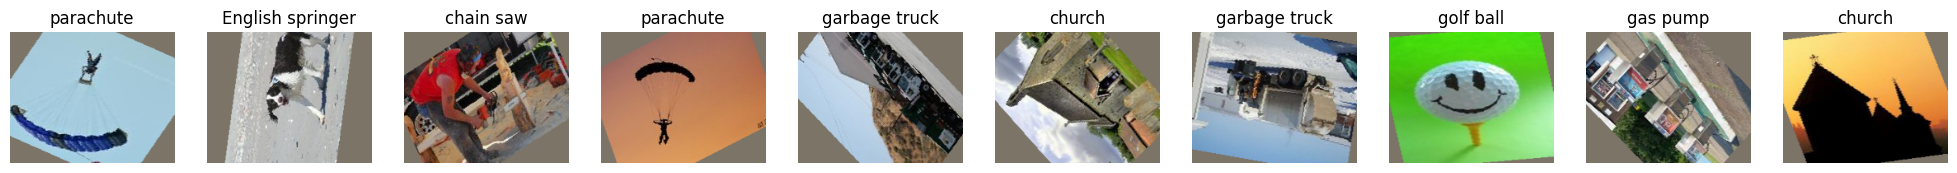

In [10]:
images, labels = next(iter(train_dataloader))
images = DeNormalize(images)
classes = [lbl_dict[list(lbl_dict.keys())[label]] for label in labels]
fig, axes = plt.subplots(figsize = (25,25), ncols=10)
for ii in range(10):
    ax = axes[ii]
    ax.imshow((images[ii]).permute(1, 2, 0)) # Unnormalize and in range (0, 255) and permutation of PIL
    ax.set_title(classes[ii])
    ax.axis('off')

#Model

Today we will use ResNet. It is a convolutional architecture using residual blocks (here BasicBlock) where the output is the sum of the input (skip connection) and the result of the input through multiple convolutions and activations. In many deep achitectures, the useful information to classify tend to be lost after many layers, but residual blocks are an effective way to counter that as the input is repeated after each residual block.

The standard implementation of ResNets is recursive and use first a 7x7 convolution and then 4 groups of multiple BasicBlocks depending on how deep you want the model to be.

You may find here a table illustrating the different proposed architectures:
<img src="https://neurohive.io/wp-content/uploads/2019/01/resnet-architectures-34-101.png">

You may refer [here](https://arxiv.org/pdf/1512.03385.pdf) for more details.

In [11]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride = 1, downsample = None,
                 groups = 1, base_width = 64, dilation = 1, norm_layer = None,):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward

def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

Build a ResNet18. You can check what are the layers of the model with print(model). Be aware that only the defined layers are printed and not the functions applied at the forward pass. So never assume that the forward pass is only an nn.Sequential (where the input goes only through defined layers). For example here, we use torch.flatten in the forward before the fully connected layer.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')
net_args = {
    "block": BasicBlock,
    "layers": [2, 2, 2, 2],
    "num_classes": 10,} # TODO
wandb.init(config=net_args)
model = ResNet(**net_args).to(device)
print(model)

Device used: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1)

In [13]:
# define optimizer, criterion and number of training epochs
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # TODO
criterion = nn.CrossEntropyLoss() # TODO
epochs = 10 # TODO

Let's define classification metrics to validate our model. Even though they are often already coded, it is important to get to know how to calculate them.

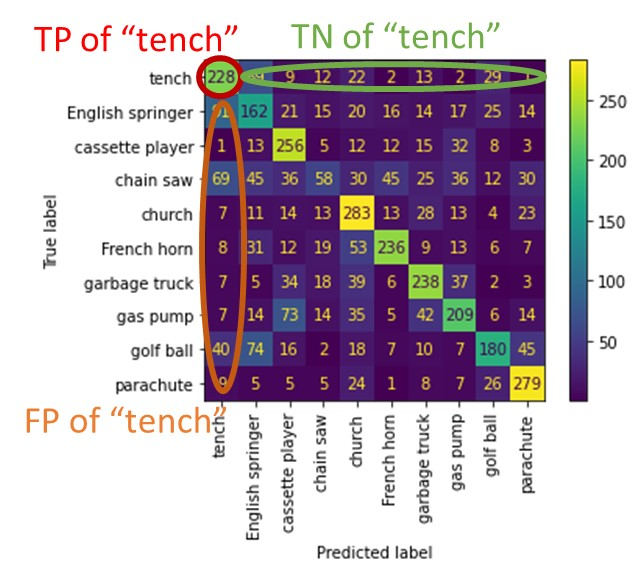

In [14]:
l = ['a', 'b', 'c']
for idx, element in enumerate(l):
    print(idx, element)

0 a
1 b
2 c


In [15]:
# Accuracy = (TP+TN)/(TP+TN+FP+FN) # How the models performs accross all classes
def accuracy(preds, labels):
    return (labels == preds).sum() / len(labels) # TODO # Argmax of logits is the argmax of the predictions (the softmax of the logits)

# Precision = TP / (TP+FP) # How reliable the model is in classifying samples as Positive
# Think about how the confusion matrix is constructed and check how it is rotated.
def precision(cm):
    return [col[i]/sum(col) for i, col in enumerate(cm.T)]# TODO

# Recall = TP / (TP+FN)
# Think about how the confusion matrix is constructed!
def recall(cm):
    return [row[i]/sum(row) for i, row in enumerate(cm)] # TODO

Here we code the learning loop that we have seen multiple times, now!

In [16]:
def training_loop(model, epochs, train_dataloader, val_dataloader, optimizer, criterion, device):
    total_train_losses = []
    total_val_losses = []

    for epoch in range(1,epochs+1):
        print(f'epoch: {epoch}')
        ##TRAINING##
        model.train()
        train_losses = []
        trn_lbl = torch.Tensor([])
        trn_preds = torch.Tensor([])
        for i, batch, in enumerate(tqdm(train_dataloader)):
            img_batch, lbl_batch = batch
            trn_lbl=torch.cat((trn_lbl, lbl_batch))
            img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

            optimizer.zero_grad()
            logits = model(img_batch)
            trn_preds=torch.cat((trn_preds, logits.argmax(1).cpu()))
            loss=criterion(logits, lbl_batch)
            wandb.log({"train_loss":loss.item()}) # log the training loss at each batch
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        train_acc=accuracy(trn_preds, trn_lbl)
        train_loss_mean = np.mean(train_losses)
        total_train_losses.append(train_loss_mean)

        ##VALIDATION##
        model.eval()
        val_losses = []
        val_lbl = torch.Tensor([])
        val_preds = torch.Tensor([])
        with torch.no_grad():

            for i, batch, in enumerate(tqdm(val_dataloader)):
                img_batch, lbl_batch = batch
                val_lbl=torch.cat((val_lbl, lbl_batch))
                img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

                logits=model(img_batch)
                val_preds=torch.cat((val_preds, logits.argmax(1).cpu()))
                loss=criterion(logits, lbl_batch)

                # confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
                val_losses.append(loss.item())

        val_acc=accuracy(val_preds, val_lbl)
        val_loss_mean = np.mean(val_losses)
        wandb.log({"train_acc":train_acc, "val_acc":val_acc, "val_loss":val_loss_mean}) # log the train & val accuracy and the val loss at each epoch
        total_val_losses.append(val_loss_mean)

    cm = confusion_matrix(val_lbl, val_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=lbl_dict.values())
    disp.plot(xticks_rotation='vertical')
    plt.show()
    print(f'Accuracy: {accuracy(val_lbl, val_preds)}')
    print(f'Precision: {precision(cm)}')
    print(f'Recall: {recall(cm)}')
    print(classification_report(val_lbl, val_preds, target_names=lbl_dict.values()))

Let's train! Feel free to change the hyperparameters: the number of epochs, the learning rate or the optimizer. You can also add a scheduler on the learning rate.

epoch: 1


100%|██████████| 122/122 [00:12<00:00,  9.95it/s]


epoch: 2


100%|██████████| 122/122 [00:12<00:00,  9.90it/s]


epoch: 3


100%|██████████| 122/122 [00:12<00:00,  9.90it/s]


epoch: 4


100%|██████████| 122/122 [00:12<00:00,  9.98it/s]


epoch: 5


100%|██████████| 122/122 [00:12<00:00,  9.87it/s]


epoch: 6


100%|██████████| 122/122 [00:12<00:00,  9.96it/s]


epoch: 7


100%|██████████| 122/122 [00:12<00:00,  9.86it/s]


epoch: 8


100%|██████████| 122/122 [00:12<00:00,  9.91it/s]


epoch: 9


100%|██████████| 122/122 [00:13<00:00,  9.05it/s]


epoch: 10


100%|██████████| 122/122 [00:12<00:00,  9.88it/s]


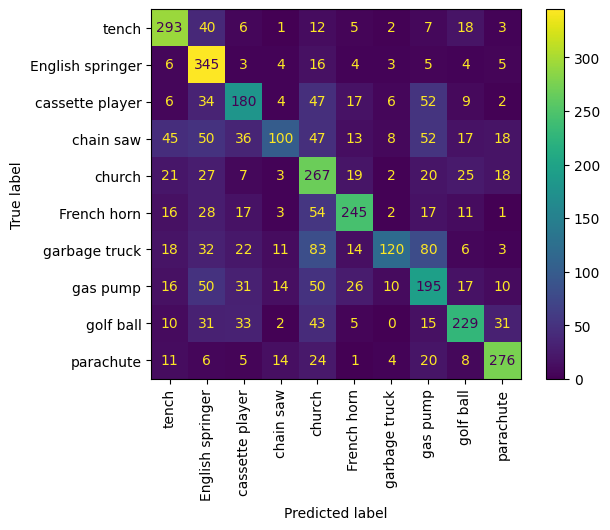

Accuracy: 0.5763319730758667
Precision: [0.6628959276018099, 0.536547433903577, 0.5294117647058824, 0.6410256410256411, 0.4152410575427683, 0.7020057306590258, 0.7643312101910829, 0.42116630669546434, 0.6656976744186046, 0.7520435967302452]
Recall: [0.7571059431524548, 0.8734177215189873, 0.5042016806722689, 0.25906735751295334, 0.6528117359413202, 0.6218274111675127, 0.30848329048843187, 0.46539379474940334, 0.5739348370927319, 0.7479674796747967]
                  precision    recall  f1-score   support

           tench       0.66      0.76      0.71       387
English springer       0.54      0.87      0.66       395
 cassette player       0.53      0.50      0.52       357
       chain saw       0.64      0.26      0.37       386
          church       0.42      0.65      0.51       409
     French horn       0.70      0.62      0.66       394
   garbage truck       0.76      0.31      0.44       389
        gas pump       0.42      0.47      0.44       419
       golf ball       0

In [17]:
training_loop(model, epochs, train_dataloader, val_dataloader, optimizer, criterion, device)

#Look at feature Maps

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1)

As you can see above resnet architecture we have a bunch of Conv2d, BatchNorm2d, and ReLU layers. But, we want to check only feature maps after Conv2d because this is the layer where actual filters were applied. So let’s extract the Conv2d layers and store them into a dict (to have their corresponding name) also extract corresponding weights and store them in a dict as well.

In [19]:
# we will save the conv layer weights in this dict
model_weights =dict()
#we will save the  conv layers in this dict
conv_layers = dict()
# get all the model children as dict
model_children = dict(model.named_children())
#counter to keep count of the conv layers
counter = 0
for name, child in model_children.items():
    if type(child) == nn.Conv2d:
        counter+=1
        model_weights[name] = child.weight
        conv_layers[name] = child
    elif type(child) == nn.Sequential:
        for j in range(len(child)):
            for sub_name, sub_child in child[j].named_children():
                if type(sub_child) == nn.Conv2d:
                    counter+=1
                    model_weights[name+'_'+str(j)+'_'+sub_name] = sub_child.weight
                    conv_layers[name+'_'+str(j)+'_'+sub_name] = sub_child
print(f"Total convolution layers: {counter}")
conv_layers

Total convolution layers: 17


{'conv1': Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 'layer1_0_conv1': Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer1_0_conv2': Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer1_1_conv1': Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer1_1_conv2': Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer2_0_conv1': Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 'layer2_0_conv2': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer2_1_conv1': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer2_1_conv2': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer3_0_conv1': Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 'layer3_0_conv2': Conv2d(128

PyTorch offers the possibility to mark Modules with a function called a hook which will be applied at specific time. For example, if we want to look at feature maps, what we want in fact to do is to store the output of a given module at the forward pass. So we will build a hook that is registered as a forward hook.

In [20]:
# Define the hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for name, module in conv_layers.items():
    module.register_forward_hook(get_activation(name))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[ 0.2222,  0.5633, -1.0857,  0.4307,  1.2383, -1.1804,  2.1761,  2.7946,
         -2.6865, -2.7557]], device='cuda:0', grad_fn=<AddmmBackward0>)

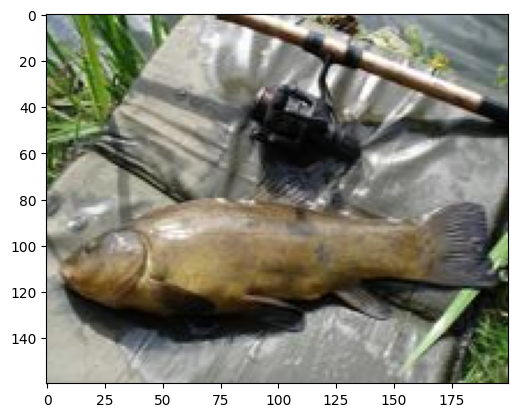

In [21]:
image = next(iter(val_dataloader))[0][0].cuda() # get a tensored input
demolized = DeNormalize(image).detach().cpu()
plt.imshow(demolized.permute(1, 2, 0)) # Base image visualization
model(image.unsqueeze(0))

torch.Size([1, 64, 80, 100])
torch.Size([1, 32, 40, 50])
torch.Size([1, 32, 40, 50])
torch.Size([1, 32, 40, 50])
torch.Size([1, 32, 40, 50])
torch.Size([1, 64, 20, 25])
torch.Size([1, 64, 20, 25])
torch.Size([1, 64, 20, 25])
torch.Size([1, 64, 20, 25])
torch.Size([1, 128, 10, 13])
torch.Size([1, 128, 10, 13])
torch.Size([1, 128, 10, 13])
torch.Size([1, 128, 10, 13])
torch.Size([1, 256, 5, 7])
torch.Size([1, 256, 5, 7])
torch.Size([1, 256, 5, 7])
torch.Size([1, 256, 5, 7])


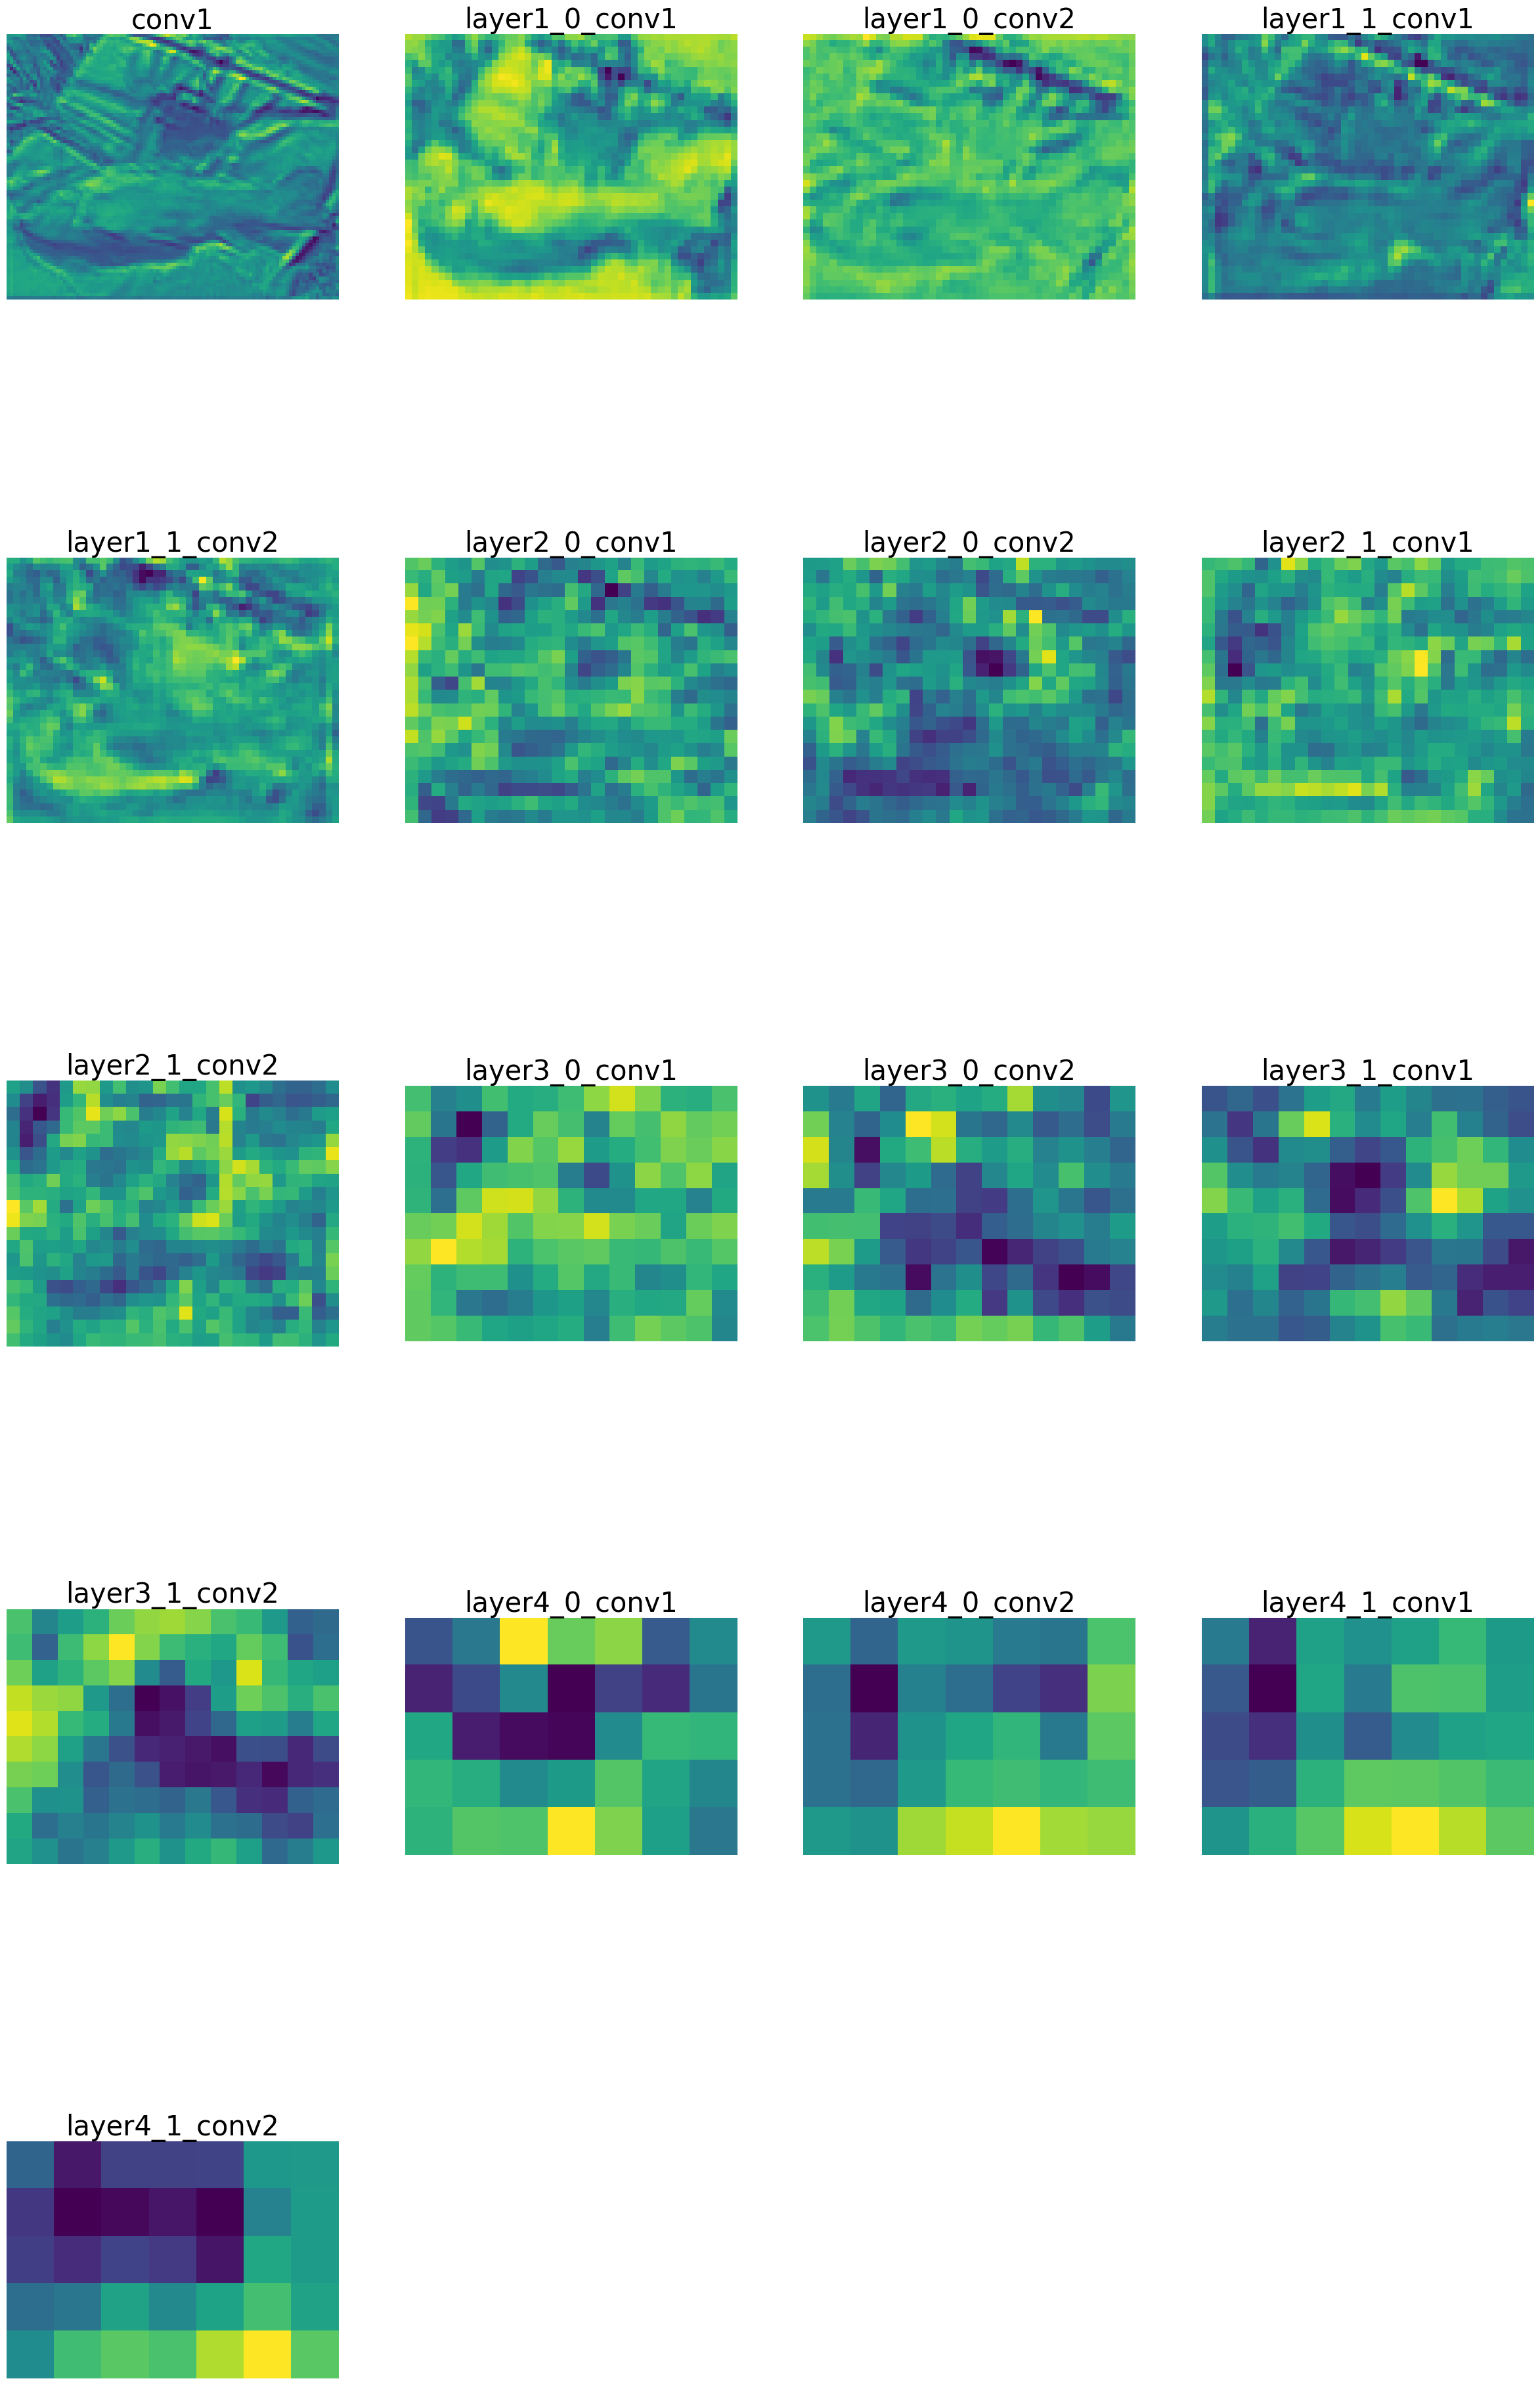

In [22]:
fig = plt.figure(figsize=(30, 50))
for i, (layer_name, feature_map) in enumerate(activation.items()):
    print(feature_map.shape)
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    gray_scale = gray_scale.data.cpu().numpy()
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(gray_scale)
    a.axis("off")
    a.set_title(layer_name.split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

# What if we use a bigger model?

train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▆▆▇▆▆▄▅▆▇▄▃▄▄▅▄▄▃▂▂▄▃▂▃▃▆▄▃▂▂▂▄▂▂▂▃▁▁▃
val_acc,▁▁▃▄▃▅▇▅▆█
val_loss,▆█▅▄▄▄▂▅▃▁
train_acc,0.65445
train_loss,0.99038
val_acc,0.57633
val_loss,1.27457


epoch: 1


  0%|          | 0/295 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 122/122 [00:14<00:00,  8.32it/s]


epoch: 2


100%|██████████| 122/122 [00:14<00:00,  8.33it/s]


epoch: 3


100%|██████████| 122/122 [00:14<00:00,  8.37it/s]


epoch: 4


100%|██████████| 122/122 [00:14<00:00,  8.32it/s]


epoch: 5


100%|██████████| 122/122 [00:14<00:00,  8.40it/s]


epoch: 6


100%|██████████| 122/122 [00:14<00:00,  8.35it/s]


epoch: 7


100%|██████████| 122/122 [00:15<00:00,  7.81it/s]


epoch: 8


100%|██████████| 122/122 [00:14<00:00,  8.30it/s]


epoch: 9


100%|██████████| 122/122 [00:14<00:00,  8.31it/s]


epoch: 10


100%|██████████| 122/122 [00:14<00:00,  8.35it/s]


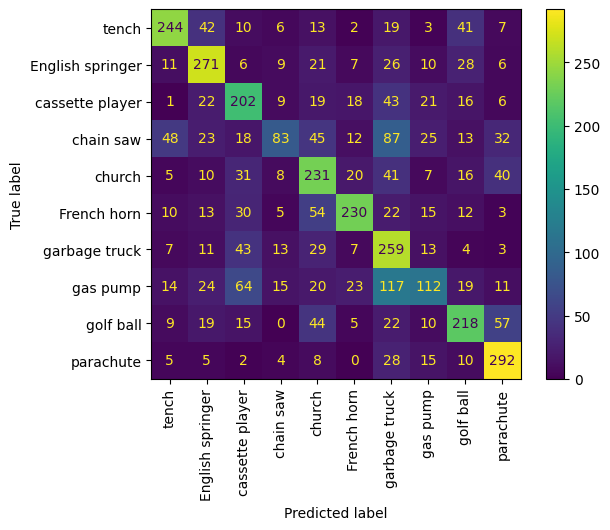

Accuracy: 0.5486680269241333
Precision: [0.6892655367231638, 0.615909090909091, 0.47980997624703087, 0.5460526315789473, 0.4772727272727273, 0.7098765432098766, 0.39006024096385544, 0.48484848484848486, 0.5782493368700266, 0.6389496717724289]
Recall: [0.6304909560723514, 0.6860759493670886, 0.5658263305322129, 0.21502590673575128, 0.5647921760391198, 0.583756345177665, 0.6658097686375322, 0.26730310262529833, 0.5463659147869674, 0.7913279132791328]
                  precision    recall  f1-score   support

           tench       0.69      0.63      0.66       387
English springer       0.62      0.69      0.65       395
 cassette player       0.48      0.57      0.52       357
       chain saw       0.55      0.22      0.31       386
          church       0.48      0.56      0.52       409
     French horn       0.71      0.58      0.64       394
   garbage truck       0.39      0.67      0.49       389
        gas pump       0.48      0.27      0.34       419
       golf ball       0

In [23]:
net_args = {
    "block": Bottleneck,
    "layers": [3, 4, 6, 3],
    "num_classes": 10,} # TODO
wandb.init(config=net_args)
resnet50 = ResNet(**net_args).to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.1) # TODO
training_loop(resnet50, epochs, train_dataloader, val_dataloader, optimizer, criterion, device)